# Verify ontology concepts in the CSpace

In this notebook we inspect ontological concepts (diseases) embedded in the CSpace.

1) isolate ontological concepts
2) compute relatedness empirical distribution
3) inspect top and bottom-related concepts
4) check coherence of CSpace concept relatedness and literature

In [1]:
from gensim.models import KeyedVectors
import compress_fasttext
import numpy as np
from commonalities import get_names
from distribution import *
import re
import pickle

## isolate ontological concepts

In [13]:
smodel = KeyedVectors.load('models/cspace.kv.bin','r')

Inspect

In [3]:
Wspecies = np.memmap('models/Wspecies.npy', mode="w+", dtype=np.float32, shape=(180344, 152))
species_key_to_index={}
Wdiseases = np.memmap('models/Wdiseases.npy', mode="w+", dtype=np.float32, shape=(5604, 152))
diseases_key_to_index={}
Wchemicals = np.memmap('models/Wchemicals.npy', mode="w+", dtype=np.float32, shape=(5630, 152))
chemicals_key_to_index={}
Wgenes = np.memmap('models/Wgenes.npy', mode="w+", dtype=np.float32, shape=(211842, 152))
genes_key_to_index={}

concept_names=['species','disease','chemical','gene']
concept_W=[Wspecies,Wdiseases,Wchemicals,Wgenes]
concept_maps=[species_key_to_index,diseases_key_to_index,chemicals_key_to_index,genes_key_to_index]
concept_patterns=[re.compile(x) for x in ['^species_[0-9]+$','^disease_mesh_d[0-9]+$','^chemical_mesh_d[0-9]+$','^gene_[0-9]+$']]

In [4]:
idxs={
    'species':0,
    'disease':0,
    'chemical':0,
    'gene':0
}
for k in smodel.key_to_index.keys():
    for n,W,Wmap,p in zip(concept_names,concept_W,concept_maps,concept_patterns):
        if p.match(k):
            i = idxs[n]
            # store to matrix W
            W[i, :] = smodel.get_vector(k,norm=True)
            # save map index_to_key
            Wmap[i]=k
            # next position
            idxs[n]+=1
            break

for W in concept_W:
    W.flush()

In [5]:
idxs

{'species': 180344, 'disease': 5604, 'chemical': 5630, 'gene': 211842}

In [6]:
Wdata = {
    'idxs':idxs,
    'names':concept_names,
    'maps':concept_maps,
    'patterns':concept_patterns,
    'paths':['models/Wspecies.npy','models/Wdiseases.npy','models/Wchemicals.npy','models/Wgenes.npy']
}

with open('models/Wdata.pkl','wb') as f:
    pickle.dump(Wdata, f)

In [2]:
with open('models/Wdata.pkl','rb') as f:
    Wdata = pickle.load(f)

In [11]:
# create a ontology-only version of cspace:
idxs=Wdata['idxs']
maps=Wdata['maps']
concepts = []
for ni,n in enumerate(Wdata['names']):
    concepts.extend(maps[ni].values())

omodel = smodel.vectors_for_all(concepts)

omodel.save('models/cspace.ontology.kv.bin')
#for n,Wpath in zip(Wdata['names'],Wdata['paths']):
#    m=maps[n]
#    wlen=idxs[n]
    


In [3]:
idxs=Wdata['idxs']
# global row-block matrix with all
Wg = np.memmap('models/Wall.npy', mode="w+", dtype=np.float32, shape=(sum([idxs[k] for k in idxs]), 152))
ig = 0
for n,Wpath in zip(Wdata['names'],Wdata['paths']):
    Wlen=idxs[n]
    W = np.memmap(Wpath, mode="r", dtype=np.float32, shape=(Wlen, 152))
    # block copy
    Wg[ig:ig+Wlen,:] = W
    ig += Wlen
    
Wg.flush()

In [4]:
ig

403420

In [5]:
# ranges for every concept
np.cumsum(list(idxs.values()))

array([180344, 185948, 191578, 403420])

Now apply an analysis similar to the one in cspace_cosine_distributions

In [6]:
Wg.shape

(403420, 152)

too big.. do it only for diseases

## compute relatedness empirical distribution


In [3]:
disease=1
Wlen = Wdata['idxs']['disease']
Wpath = Wdata['paths'][disease]
dmap = Wdata['maps'][disease]

Wdiseases = np.memmap(Wpath, mode="r", dtype=np.float32, shape=(Wlen, 152))

Wsq = Wdiseases @ Wdiseases.T
Wsq.shape

(5604, 5604)

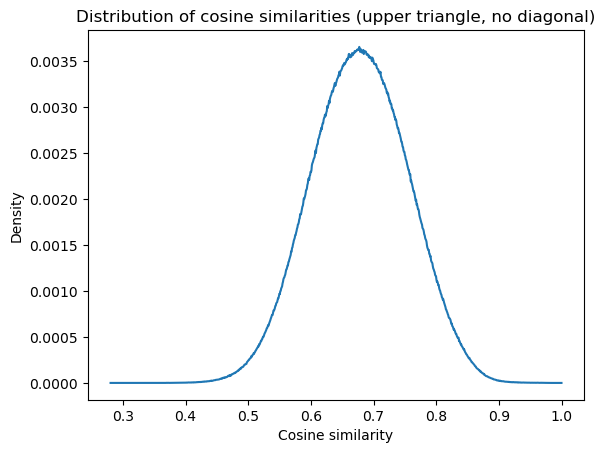

Distribution diagnostics: {'n': 5604, 'expected_pairs': 15699606, 'counted_pairs': 15699606, 'dropped_pairs': 0, 'nan_count': 0, 'inf_count': 0, 'min_seen': 0.27934199571609497, 'max_seen': 0.9893831014633179, 'cdf_last': 0.9999999363041334, 'hist_range': (0.28, 1.0), 'bins': 1000}


In [4]:
# 1) Distribution (upper triangle, no diagonal)

bin_edges, hist_counts, pdf, cdf, stats = build_distribution(Wsq, bins=BINS, hist_range=(0.28, 1.0), row_block=ROW_BLOCK)

In [5]:
# print quantile thresholds
minimum, maximum = quantile_thresholds_from_hist(bin_edges, hist_counts, cdf, LO_Q, HI_Q)
print(f"Approx min-sim threshold (~{LO_Q*100:.2f}th pct): {minimum:.4f}")

low, middle = quantile_thresholds_from_hist(bin_edges, hist_counts, cdf, 0.25, 0.5)
print(f"Approx low-sim threshold (~{25:.2f}th pct): {low:.4f}")

middle, high = quantile_thresholds_from_hist(bin_edges, hist_counts, cdf, 0.5, 0.75)
print(f"Approx middle-sim threshold (~{50:.2f}th pct): {middle:.4f}")
print(f"Approx high-sim threshold (~{75:.2f}th pct): {high:.4f}")

print(f"Approx max-sim threshold (~{HI_Q*100:.2f}th pct): {maximum:.4f}")


Approx min-sim threshold (~0.10th pct): 0.4492
Approx low-sim threshold (~25.00th pct): 0.6242
Approx middle-sim threshold (~50.00th pct): 0.6774
Approx high-sim threshold (~75.00th pct): 0.7307
Approx max-sim threshold (~99.90th pct): 0.8920


It looks like ontology identifiers have statistically higher similarities among them w.r.t. general concepts

## inspect top and bottom-related concepts


In [7]:
# Show samples of very similar and very dissimilar entries
top, bottom = find_extremes(Wsq, k=20, row_block=ROW_BLOCK)


In [8]:

print("\nTop (very similar) off-diagonal pairs:")
for val, i, j in top:
    (n_i,_), (n_j,_) = get_names([(dmap[i],None),(dmap[j],None)])
    print(f"{n_i} ≈ {n_j} ({val:.6f})")

print("\nBottom (very dissimilar) off-diagonal pairs:")
for val, i, j in bottom:
    (n_i,_), (n_j,_) = get_names([(dmap[i],None),(dmap[j],None)])
    print(f"{n_i} ≈ {n_j} ({val:.6f})")



Top (very similar) off-diagonal pairs:
Coxa Vara ≈ Coxa Valga (0.989383)
Psychoses, Substance-Induced ≈ Psychotic Disorders (0.985656)
Colitis, Collagenous ≈ Colitis, Lymphocytic (0.982035)
Chondromatosis ≈ Osteochondromatosis (0.980452)
Aortic Root Aneurysm ≈ Aneurysm, Aortic Arch (0.979565)
d0093692 ≈ d00936923 (0.979155)
Genu Varum ≈ Genu Valgum (0.978877)
Spondylarthropathies ≈ Spondylarthritis (0.978192)
Tuberculosis, Cardiovascular ≈ Tuberculosis, Endocrine (0.978108)
Aneurysm, Ascending Aorta ≈ Dissection, Thoracic Aorta (0.977967)
Dissection, Thoracic Aorta ≈ Aortic Aneurysm, Thoracoabdominal (0.977927)
d0019434 ≈ d0019433 (0.977583)
d0002755 ≈ d0002756 (0.977523)
d0103009 ≈ d0103007 (0.977492)
Cystadenoma, Serous ≈ Cystadenoma, Mucinous (0.977323)
Breast Neoplasms ≈ d0019433 (0.977215)
Pre-Excitation Syndromes ≈ Pre-Excitation, Mahaim-Type (0.977093)
Anemia, Refractory ≈ Anemia, Refractory, with Excess of Blasts (0.977028)
Cystadenoma ≈ Cystadenocarcinoma (0.976956)
Lung Inju

the first results can help ontology curators to cut down the number of ontology entities for extremely similar concepts.

In [14]:
smodel.similarity( 'disease_mesh_d015658015658', 'disease_mesh_d015658' )

0.91930604

**ERROR**: there are some mesh with duplicated ID, as in the last cell

## check coherence of CSpace concept relatedness and literature

Now, have a look at similar values at a given percentile:

In [6]:
low_list = find_pairs_near_percentile(Wsq, bin_edges, cdf, target_percentile=0.25, k=20)
middle_list = find_pairs_near_percentile(Wsq, bin_edges, cdf, target_percentile=0.50, k=20)
high_list = find_pairs_near_percentile(Wsq, bin_edges, cdf, target_percentile=0.75, k=20)
# (abs_diff_from_0.95, i, j, similarity_value, value_percentile)

In [12]:
print("\nLow (very dis-similar) pairs:")
for abs_diff, i, j, val, perc in low_list:
    (n_i,_), (n_j,_) = get_names([(dmap[i],None),(dmap[j],None)])
    print(f"{n_i} ≈ {n_j} ({val:.6f} ({perc*100:.1f}%))")

print("\nMiddle (neutral) pairs:")
for abs_diff, i, j, val, perc in middle_list:
    (n_i,_), (n_j,_) = get_names([(dmap[i],None),(dmap[j],None)])
    print(f"{n_i} ≈ {n_j} ({val:.6f}) ({perc*100:.1f}%)")

print("\nHigh (very similar) pairs:")
for abs_diff, i, j, val, perc in high_list:
    (n_i,_), (n_j,_) = get_names([(dmap[i],None),(dmap[j],None)])
    print(f"{n_i} ≈ {n_j} ({val:.6f}) ({perc*100:.1f}%)")



Low (very dis-similar) pairs:
Ovarian Hyperstimulation Syndrome ≈ d0022779606 (0.624872 (25.0%))
Venous Thrombosis ≈ Otitis (0.624872 (25.0%))
Pemphigus, Benign Familial ≈ Paranoid Personality Disorder (0.624872 (25.0%))
Chronic Periodontitis ≈ Gonadal Dysgenesis, 46,XY (0.624872 (25.0%))
Multiple Sclerosis ≈ Piscirickettsiaceae Infections (0.624872 (25.0%))
Pancreas Divisum ≈ Sluggish Cognitive Tempo (0.624872 (25.0%))
Haemophilus Infections ≈ Bowen's Disease (0.624872 (25.0%))
Wolf-Hirschhorn Syndrome ≈ d0064809606 (0.624872 (25.0%))
Pulmonary Alveolar Proteinosis ≈ d0000692799606 (0.624872 (25.0%))
Pain Insensitivity, Congenital ≈ Spherocytosis, Hereditary (0.624872 (25.0%))
Psychological Trauma ≈ Micronuclei, Chromosome-Defective (0.624872 (25.0%))
Necrosis ≈ Ganglioglioma (0.624872 (25.0%))
Spondylitis, Ankylosing ≈ d0064809606 (0.624872 (25.0%))
T-Lymphocytopenia, Idiopathic CD4-Positive ≈ Alexia, Pure (0.624872 (25.0%))
Hypobetalipoproteinemia, Familial, Apolipoprotein B ≈ Pneu

Are those reasonable? let's see if they correlate with literature occurrences of both diseases

In [8]:
from pubtator_utils import *

In [9]:
# 2) Provide a name lookup that maps row index -> PubTator concept name
# If dmap[i] already returns the readable name used in your prints:
def name_lookup(i: int) -> str:
    t = list(get_names([(dmap[i],None)]))  # e.g., "Thoracic Neoplasms" -> slug becomes "Thoracic_Neoplasms"
    return t[0][0]

# 3) Count literature hits for each set (optionally pass api_key="..."):
low_literature = count_pairs_in_literature(low_list, name_lookup=name_lookup, entity_prefix="@DISEASE_", api_key=None)
middle_literature = count_pairs_in_literature(middle_list, name_lookup=name_lookup, entity_prefix="@DISEASE_", api_key=None)
high_literature = count_pairs_in_literature(high_list, name_lookup=name_lookup, entity_prefix="@DISEASE_", api_key=None)


In [16]:
low_literature[1]

{'i': 192,
 'j': 459,
 'name_i': 'Venous Thrombosis',
 'name_j': 'Otitis',
 'cosine': 0.6248719096183777,
 'count': 261}

In [15]:

high_literature[1]

{'i': 3053,
 'j': 3655,
 'name_i': 'Thoracic Neoplasms',
 'name_j': 'Langerhans Cell Sarcoma',
 'cosine': 0.7311422824859619,
 'count': 2}

Counts are typically heavy-tailed; 

Pearson can be dominated by a few very common pairs. 
Correlating with log1p(count) for a Pearson-friendly scale:

In [23]:
# correlation between CSpace low-relatedness concepts and log(co-occurrence count) in literature
for r in low_literature:
    r["count"] = None if r["count"] is None else int(r["count"])
xs = np.array([r["cosine"] for r in low_literature if r["count"] is not None], float)
ys = np.array([math.log1p(r["count"]) for r in low_literature if r["count"] is not None], float)
print("Pearson on log1p(count):", float(np.corrcoef(xs, ys)[0,1]))

Pearson on log1p(count): 0.08023448179962082


In [24]:
# correlation between CSpace middle-relatedness concepts and log(co-occurrence count) in literature
for r in middle_literature:
    r["count"] = None if r["count"] is None else int(r["count"])
xs = np.array([r["cosine"] for r in middle_literature if r["count"] is not None], float)
ys = np.array([math.log1p(r["count"]) for r in middle_literature if r["count"] is not None], float)
print("Pearson on log1p(count):", float(np.corrcoef(xs, ys)[0,1]))

Pearson on log1p(count): 0.184832388524388


In [25]:
# correlation between CSpace high-relatedness concepts and log(co-occurrence count) in literature
for r in high_literature:
    r["count"] = None if r["count"] is None else int(r["count"])
xs = np.array([r["cosine"] for r in high_literature if r["count"] is not None], float)
ys = np.array([math.log1p(r["count"]) for r in high_literature if r["count"] is not None], float)
print("Pearson on log1p(count):", float(np.corrcoef(xs, ys)[0,1]))

Pearson on log1p(count): 0.44233422728783706


CSpace embeddings **positively correlates with number of concept co-occurrence in literature**, 

another interesting fact supporting it's ability to effectively **summarize** and **capture the essence** of the relations between concepts described in literature.